## 🔬 Segmenting Mitochondria Using Thresholding Methods

In this section, we explore different thresholding techniques to segment mitochondria from fluorescence microscopy images.

We will:
- Read a single-channel mitochondrial image.
- Apply a median filter to reduce noise.
- Apply a thresholding method (Otsu, Yen, Li, etc.) — students can experiment by changing the method.
- Visualize:
  - The original image
  - The filtered (preprocessed) image
  - The binary mask (thresholded)
  - The overlay of the segmentation mask on the original image

You can try different methods by changing the `method` parameter in the code cell. Try changing `method = "otsu"` to `"yen"` or `"li"` to see how different thresholding methods affect the segmentation.


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.filters import threshold_local
from skimage.morphology import disk, remove_small_objects
from skimage.filters.rank import median
from skimage.filters import threshold_otsu, threshold_yen, threshold_li, threshold_triangle, threshold_mean
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
from skimage.measure import label
from pathlib import Path

In [9]:
def load_and_preprocess_mito_image(path):
    img = imageio.imread(path)#.astype(np.uint8)
    
    img = rescale_intensity(img)
    img = median(img, disk(2))
    img = (equalize_adapthist(img, clip_limit=0.01) * 255).astype(np.uint8)

    return img

def apply_global_threshold(img, method="otsu", min_size=0):
    # All supported methods in a dictionary
    methods = {
        "otsu": threshold_otsu,
        "yen": threshold_yen,
        "li": threshold_li,
        "triangle": threshold_triangle,
        "mean": threshold_mean
    }

    if method not in methods:
        raise ValueError(f"Unsupported thresholding method: {method}")

    thresh_val = methods[method](img)
    binary = img > thresh_val

    if min_size > 0:
        binary = remove_small_objects(binary, min_size=min_size)

    return binary.astype(np.uint8)

def plot_segmentation(original, preprocessed, mask, method_name):
    boundary_overlay = mark_boundaries(preprocessed, mask, color=(1, 0, 0))  # red boundaries

    #fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.ravel()  # Flatten to 1D for easier indexing

    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("Original Image")

    axs[1].imshow(preprocessed, cmap="gray", vmin=0, vmax=255)
    axs[1].set_title("Preprocessed")

    axs[2].imshow(mask, cmap="gray", vmin=0, vmax=1)
    axs[2].set_title(f"Binary Mask ({method_name})")

    axs[3].imshow(boundary_overlay)
    axs[3].set_title("Overlay (Boundaries)")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


3118235996.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
1906081528.py (2): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


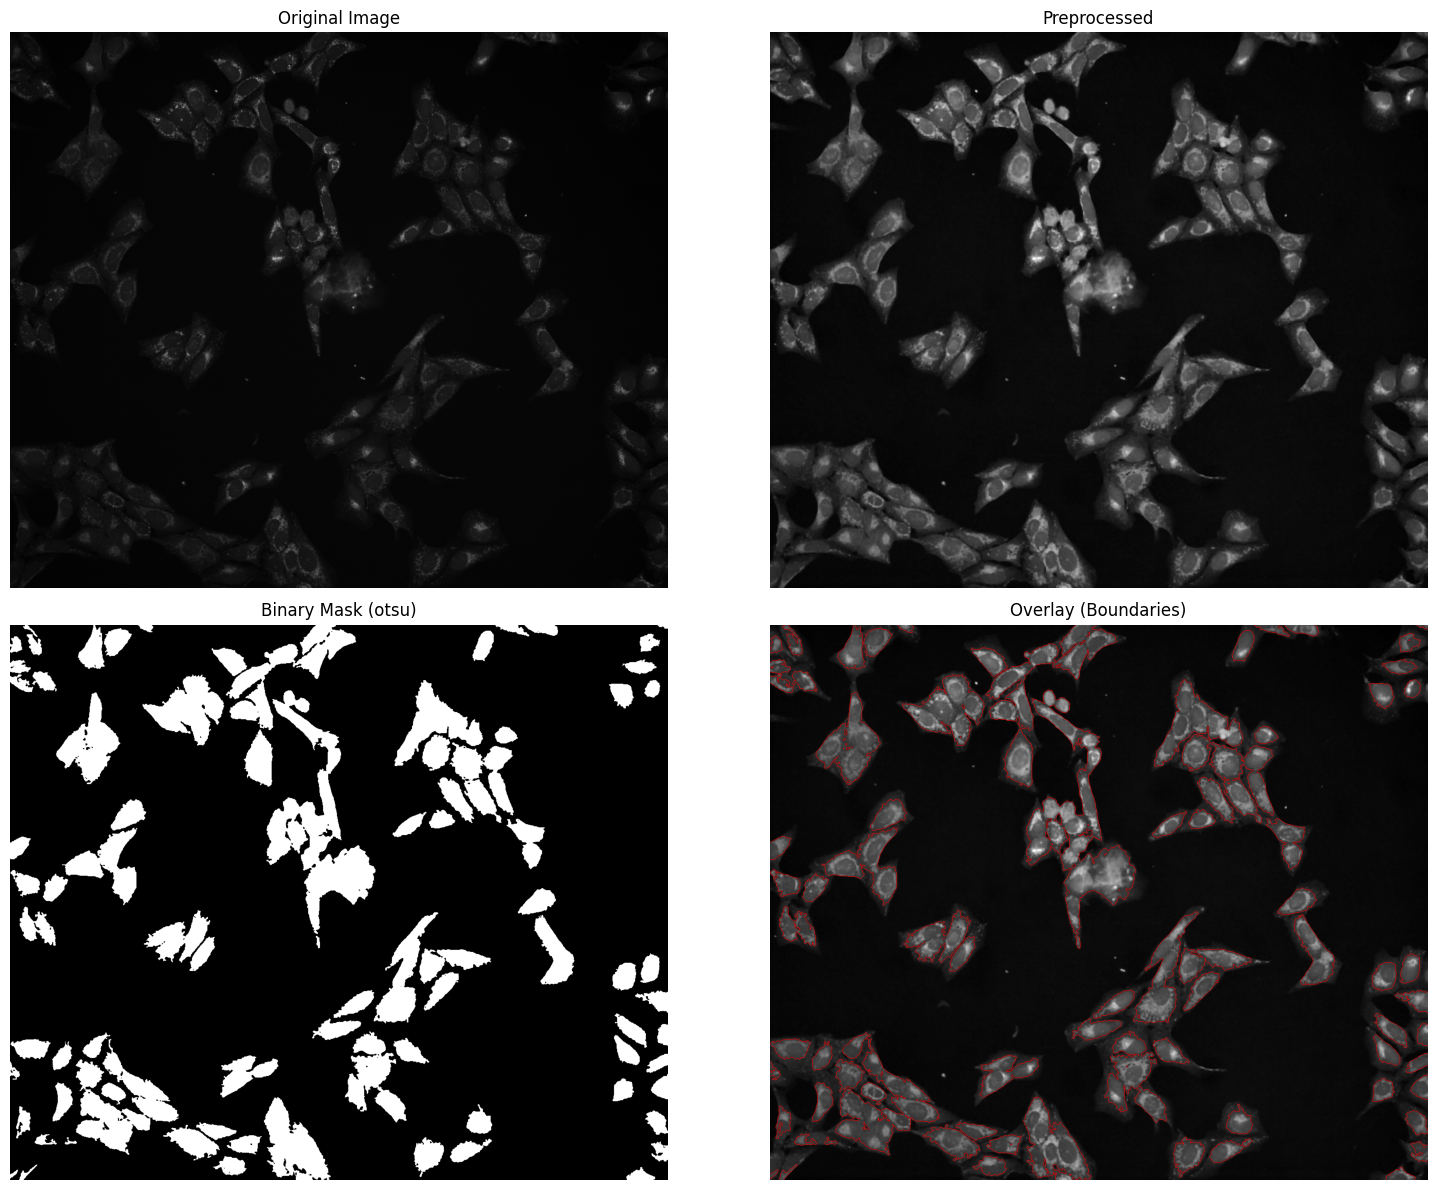

In [10]:
# === Try it ===
image_path = Path("/Users/giselemiranda/MirandaLab/Collaborations/Marcelo-Unicamp/workshop-unicamp/data_day2/JUMP-CP_mini/Brefeldin-A-like/Orig/Mito/CP1-SC1-08_P06_T0001F001L01A01Z01C02.tif")  # ← update this

original = imageio.imread(image_path)
preprocessed = load_and_preprocess_mito_image(image_path)
binary_mask = apply_global_threshold(preprocessed,"otsu",100)
plot_segmentation(original, preprocessed, binary_mask,"otsu")

## 🔬 Segmenting Nuclei with Thresholding and StarDist

In this section, we demonstrate two approaches for segmenting nuclei:

1. **Otsu Thresholding**: A traditional global thresholding method that separates foreground and background based on histogram intensity peaks. This is combined with `remove_small_objects` to clean up the result.
2. **StarDist**: A deep learning model that detects and segments star-convex shapes, particularly effective for nuclei in fluorescence images.

We will:
- Load and preprocess a nuclei (DNA) image.
- Segment the nuclei using Otsu thresholding and label the connected components.
- Segment the same image using StarDist.
- Visualize and compare both segmentation outputs.

You can use this comparison to evaluate the performance trade-offs between classical and deep learning-based methods.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.measure import label
from csbdeep.utils import normalize
from stardist.models import StarDist2D


1906081528.py (2): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


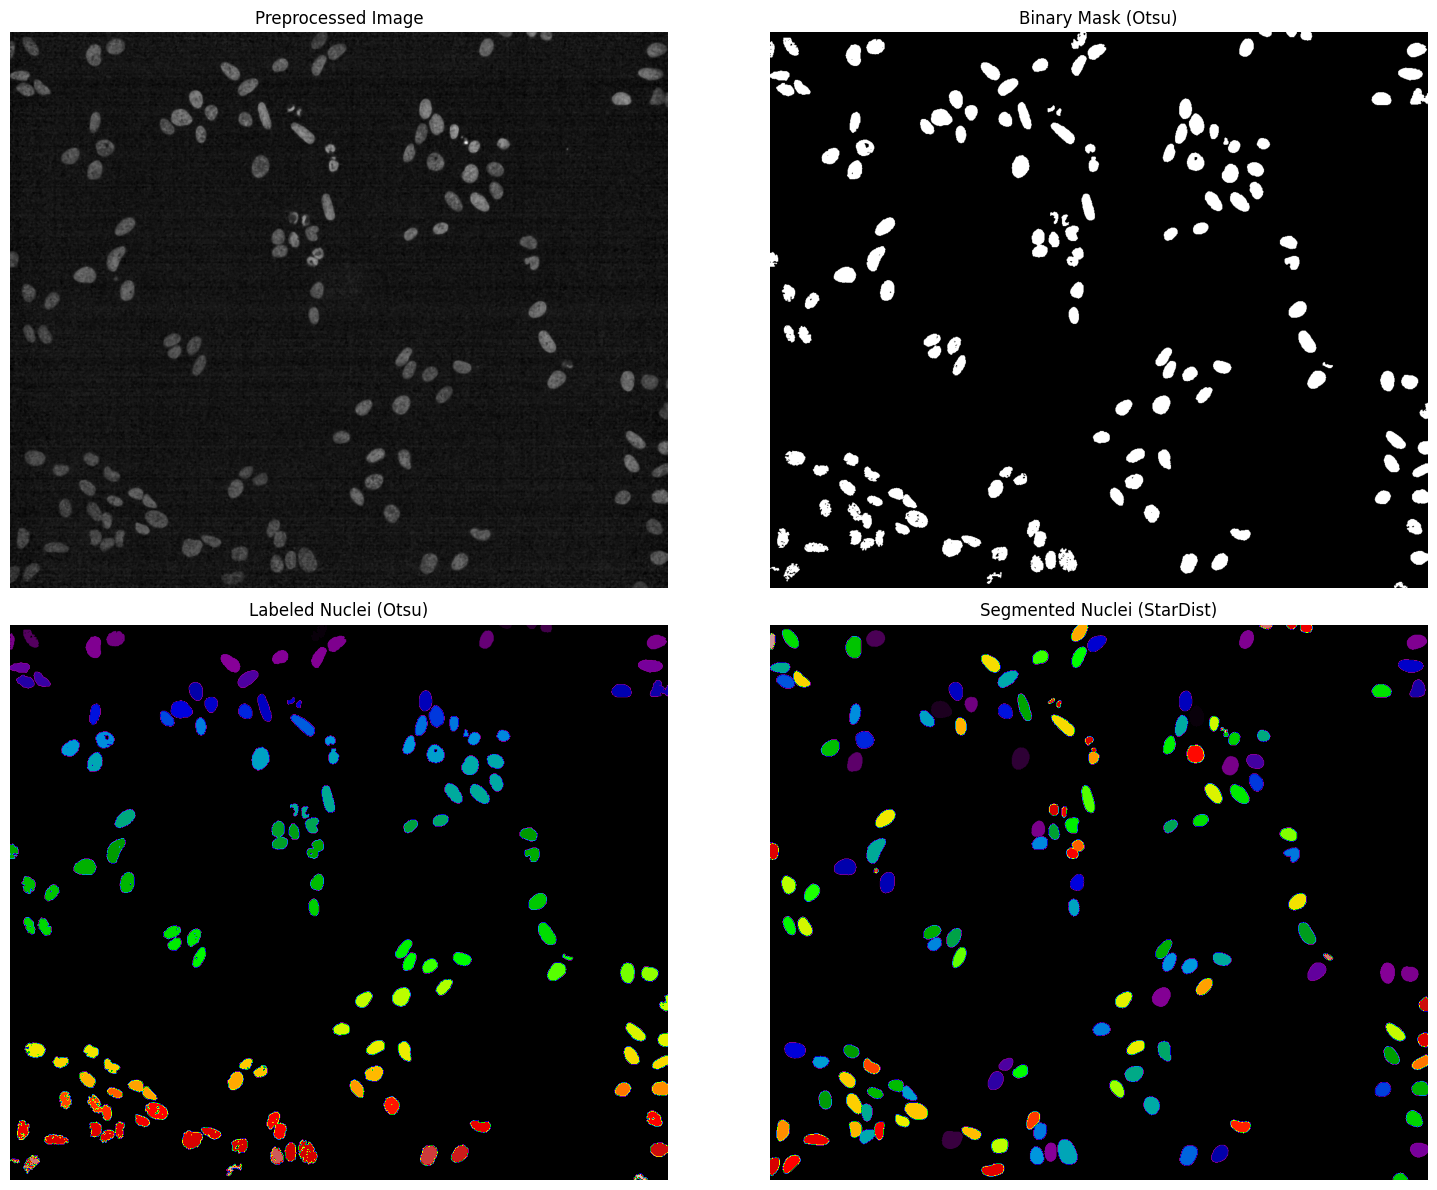

In [12]:

# === Parameters ===
image_path = Path("/Users/giselemiranda/MirandaLab/Collaborations/Marcelo-Unicamp/workshop-unicamp/data_day2/JUMP-CP_mini/Brefeldin-A-like/Orig/DNA/CP1-SC1-08_P06_T0001F001L01A01Z01C01.tif") 
method = "otsu"
min_size = 50

# === Load & preprocess image ===
preprocessed = load_and_preprocess_mito_image(image_path)  # Reuse same function

# === Segment with global thresholding (Otsu) ===
binary_thresh = apply_global_threshold(preprocessed, method=method, min_size=min_size)
labeled_thresh = label(binary_thresh)

# === Segment with StarDist ===
model = StarDist2D.from_pretrained("2D_versatile_fluo")  # DNA-style data
stardist_labels, _ = model.predict_instances(normalize(preprocessed))

# === Plotting ===
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()  # Flatten to 1D for easier indexing

axs[0].imshow(preprocessed, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Preprocessed Image")

axs[1].imshow(binary_thresh, cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Binary Mask (Otsu)")

axs[2].imshow(labeled_thresh, cmap="nipy_spectral")
axs[2].set_title("Labeled Nuclei (Otsu)")

axs[3].imshow(stardist_labels, cmap="nipy_spectral")
axs[3].set_title("Segmented Nuclei (StarDist)")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()


### 🧠 Exercise: Counting Segmented Objects

Can you implement a piece of code that **counts the number of segmented nuclei** in both outputs?

You should count:
- The number of labeled objects in the Otsu thresholded result
- The number of labeled objects in the StarDist result

---

#### 💡 Hints:
- The function [`skimage.measure.label`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) assigns a unique ID to each connected region in a binary image.
- The output of `label()` can be analyzed with `np.unique()` or `regionprops_table()` to count labels.
- Make sure to **exclude label `0`** (the background) when counting!

In [ ]:
## TODO: add code here

## 🧬 Cell Segmentation with Cellpose (Cyto3)

In this section, we explore how the Cellpose model performs segmentation of whole cells using the **Cyto3 model**.

We compare two configurations:

1. **Cell image only (Cyto3)**: segments cells using cytoplasmic channels (e.g., AGP, ER).
2. **Cell + Nuclei image (Cyto3 + DNA)**: provides the nuclei as auxiliary input to help refine cell boundaries.

This comparison helps illustrate the benefit of multi-channel segmentation using Cellpose.


In [27]:
from cellpose import models
from skimage.segmentation import mark_boundaries
import imageio
import matplotlib.pyplot as plt

In [41]:
# === User-defined Cellpose parameters ===
# For examples of parameter values visit https://forum.image.sc/t/cellpose-flow-and-cell-threshold/70347/4

diameter = 45              # Approximate diameter of cells in pixels
flow_threshold = 0.4      # Mask confidence cutoff (lower = more cells, more false positives)
cellprob_threshold = 0  # Lower = more permissive to cell detection

1906081528.py (2): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


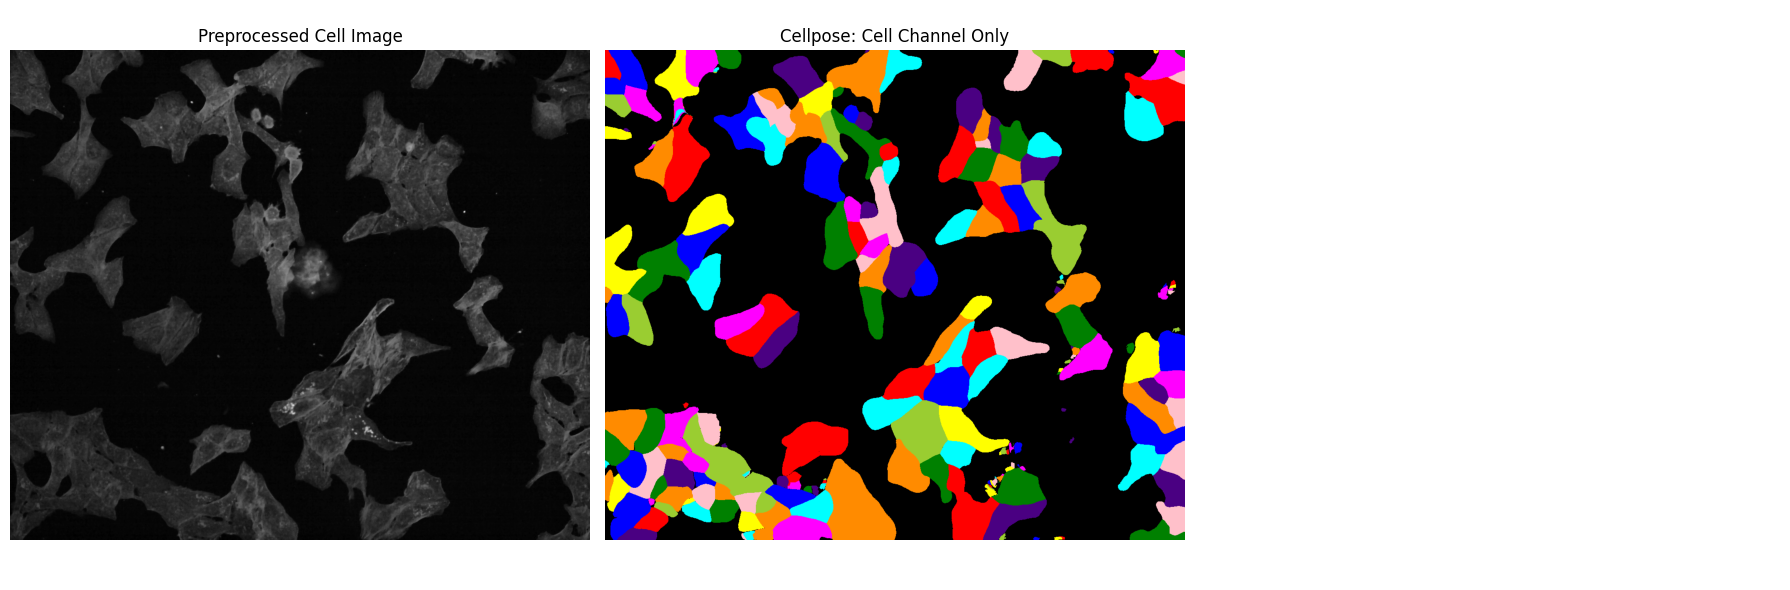

In [52]:
from skimage.exposure import rescale_intensity


# === Load cell and nuclei images ===
agp_image_path = Path("/Users/giselemiranda/MirandaLab/Collaborations/Marcelo-Unicamp/workshop-unicamp/data_day2/JUMP-CP_mini/Brefeldin-A-like/Orig/AGP/CP1-SC1-08_P06_T0001F001L01A04Z01C05.tif")     # AGP or ER or both merged
nuclei_image_path = Path("/Users/giselemiranda/MirandaLab/Collaborations/Marcelo-Unicamp/workshop-unicamp/data_day2/JUMP-CP_mini/Brefeldin-A-like/Orig/DNA/CP1-SC1-08_P06_T0001F001L01A01Z01C01.tif") # DNA
er_image_path = Path("/Users/giselemiranda/MirandaLab/Collaborations/Marcelo-Unicamp/workshop-unicamp/data_day2/JUMP-CP_mini/Brefeldin-A-like/Orig/ER/CP1-SC1-08_P06_T0001F001L01A03Z01C04.tif") # ER

agp_img = load_and_preprocess_mito_image(agp_image_path)
nuclei_img = load_and_preprocess_mito_image(nuclei_image_path)
er_img = load_and_preprocess_mito_image(er_image_path)


# === normalize begore stacking ===
agp_img = rescale_intensity(agp_img, out_range=(0,1))
nuclei_img = rescale_intensity(nuclei_img, out_range=(0,1))
er_img = rescale_intensity(er_img, out_range=(0,1))

# === Stack images for Cellpose (2 channels) ===
stacked_cell_img = np.stack([agp_img, er_img], axis=-1)
stacked_img = np.stack([agp_img, er_img, nuclei_img], axis=-1)

# === Initialize model ===
model = models.Cellpose(model_type="cyto3", gpu=False)

# === Segmentation with cell channel only ===
#masks_cellonly, *_ = model.eval(stacked_cell_img, channels=[0, 0])  # one-channel input
masks_cellonly, _, _, _ = model.eval(stacked_img,diameter=60,flow_threshold=2,cellprob_threshold=-6,channels=[0,0])

# === Segmentation with cell + nuclei ===
#masks_cellnuc, *_ = model.eval(stacked_img, channels=[1, 0])  # two-channel input

# === Visualization ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))





labeled_cells = label(masks_cellonly)  # ensure proper labeling if needed
overlay = label2rgb(labeled_cells, image=img, bg_label=0, alpha=1)






axs[0].imshow(cell_img, cmap="gray", vmin=0, vmax=255)
axs[0].set_title("Preprocessed Cell Image")

axs[1].imshow(overlay)
axs[1].set_title("Cellpose: Cell Channel Only")

#axs[2].imshow(mark_boundaries(cell_img, masks_cellnuc, color=(0, 1, 0)))
#axs[2].set_title("Cellpose: Cell + Nuclei Channels")

for ax in axs:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [38]:
print(cell_img.shape, nuclei_img.shape)

(1080, 1280) (1080, 1280)
